In [5]:
# ===================================
# !!! SET UP PATH AND MERGE FILES !!!
# ===================================

import csv
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
import os

Nchunk = 20
trials = 1e4
folder = '/home/ambra/Desktop/cluster-morgana/run0406_1e4detOnly_Ebl_noCut_Degr_noSort/' 
os.system('mkdir %spng' %folder)
path = folder + 'run0406_det/run0406_ID000126/csv/'

texp = [1,5,10,100]
sigma = [5]
chunk = [i+1 for i in range(Nchunk)]

csvName = [[]*i for i in range(len(texp))]
for i in range(len(chunk)) :  
    for j in range(len(texp)) :
        csvName[j].append('run0406_%ds_chunk%02d.csv' % (texp[j], chunk[i]))
        
# merge files ---!
csvMerged= []
for j in range(len(texp)) :
    csvMerged.append('run0406_ebl%dx_%ds.csv' % (trials,texp[j]))

    fout = open(path+csvMerged[j],'w+')
    # first file ---!
    for line in open(path+csvName[j][0]):
        fout.write(line)
    # remaining files ---!    
    for i in range(len(chunk)-1):
        f = open(path+csvName[j][i+1])
        next(f) # skip the header ---!
        for line in f:
             fout.write(line)
        f.close() 
    fout.close()
    
print(csvMerged)

for f in csvMerged:
    with open(path+f, 'r') as inp, open(path+f.replace('.csv', '_mod.csv'), 'w') as out:
        writer = csv.writer(out)
        for row in csv.reader(inp):
            if len(row) == 6 and ('ID' in row[0] or '#' in row[0]):
                writer.writerow(row)


for index, f in enumerate(csvMerged):
    csvMerged[index] = f.replace('.csv', '_mod.csv')
print(csvMerged)

# data params ---!
threshold = 0.5
xlim=0.2
texp=[1,5,10,100]
# initialize SphDistance calc ---!
trueRA = 33.057
trueDEC = -51.841
true_coord = SkyCoord(ra = trueRA*u.deg, dec = trueDEC*u.deg, frame='fk5')
# conf intervals params ---!
nstd = [1,2,3,5]
conf_probs = [0.6827, 0.9545, 0.9973, 0.99994]
# img params ---!
fontsize=12
CI_colors = ['k', 'r', 'g', 'w']

['run0406_ebl10000x_1s.csv', 'run0406_ebl10000x_5s.csv', 'run0406_ebl10000x_10s.csv', 'run0406_ebl10000x_100s.csv']
['run0406_ebl10000x_1s_mod.csv', 'run0406_ebl10000x_5s_mod.csv', 'run0406_ebl10000x_10s_mod.csv', 'run0406_ebl10000x_100s_mod.csv']


verify trials =  40895
verify trials =  10000


================ texp = 1s ==============


ZERO DETECTION RATE : 17.230000000000004
DETECTION RATE : 82.77
DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 59.31999999999999
ra det mean: 33.05810087025003 ra det std: 0.06815277530312633
dec det mean: -51.840077614437305 dec det std: 0.04244968072579578
pos det mean: 0.04941178240110339 pos det std: 0.03368594854958584


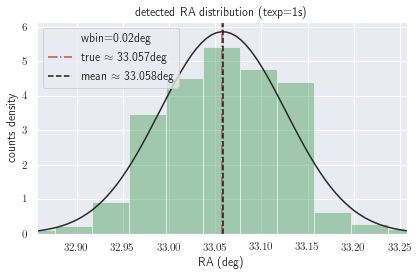

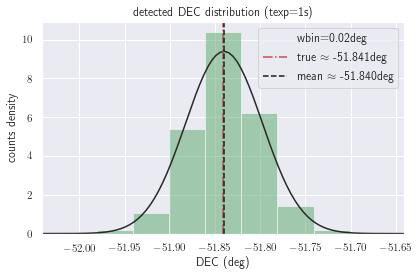

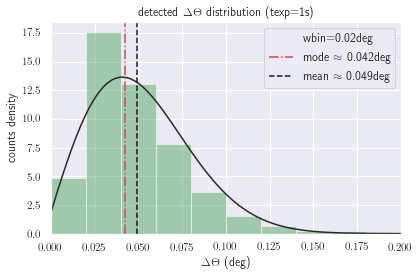

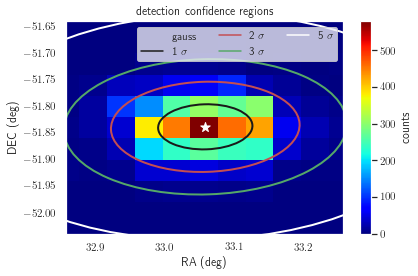

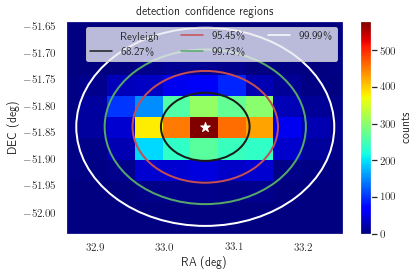

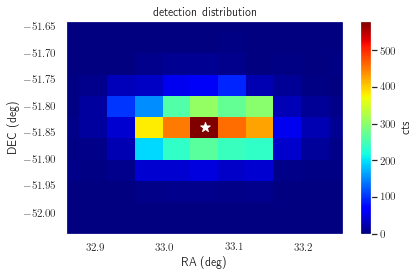



================ texp = 5s ==============


ZERO DETECTION RATE : 0.22999999999998977
DETECTION RATE : 99.77000000000001
DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 99.77000000000001
ra det mean: 33.0575448141198 ra det std: 0.03308666571760043
dec det mean: -51.84042572909924 dec det std: 0.0203564939569583
pos det mean: 0.025300202697217365 pos det std: 0.013879130662666493


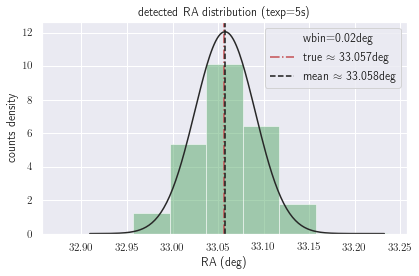

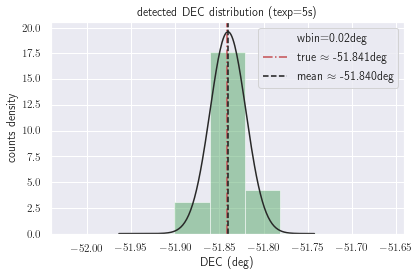

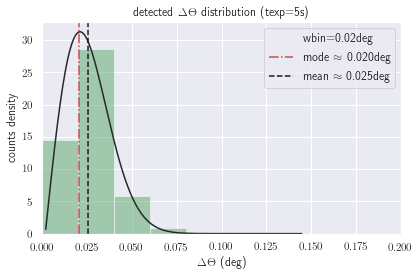

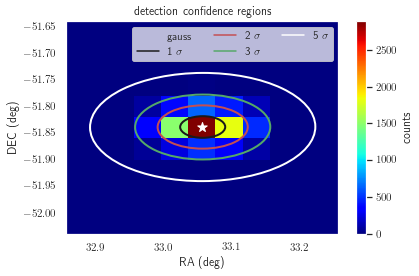

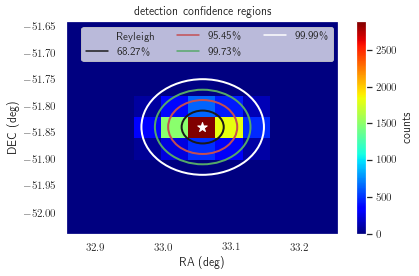

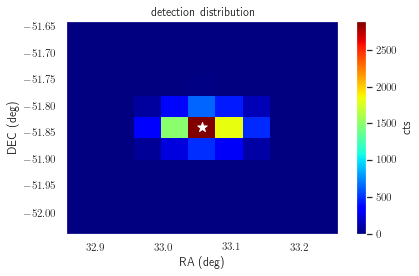



================ texp = 10s ==============


ZERO DETECTION RATE : 0.0
DETECTION RATE : 100.0
DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0
ra det mean: 33.057491507360965 ra det std: 0.024637651274564097
dec det mean: -51.840492510730385 dec det std: 0.015101356956105717
pos det mean: 0.019061314465040766 pos det std: 0.009838077937963687


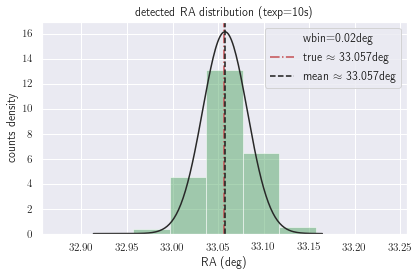

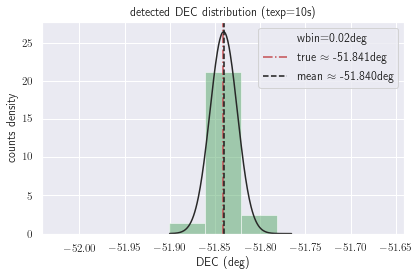

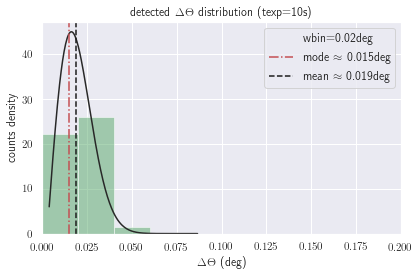

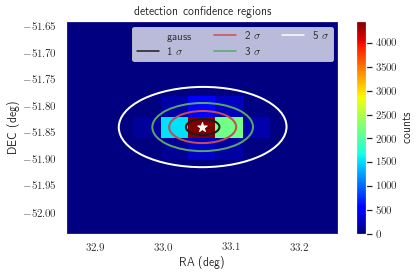

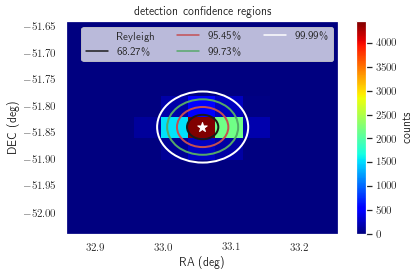

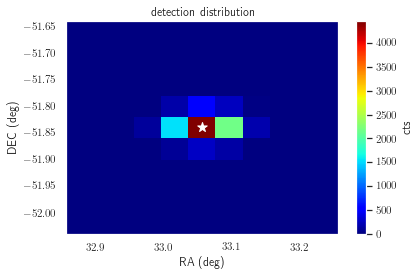



================ texp = 100s ==============


ZERO DETECTION RATE : 0.0
DETECTION RATE : 100.0
DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0
ra det mean: 33.05658718661574 ra det std: 0.012529290700010081
dec det mean: -51.840455968219274 dec det std: 0.009959152982760356
pos det mean: 0.011712697340635868 pos det std: 0.004720690330039607


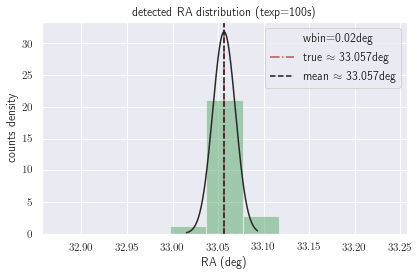

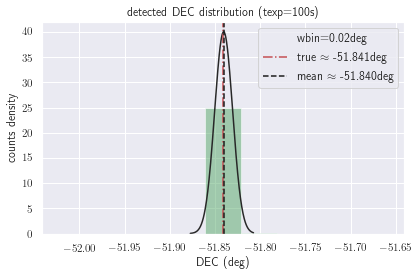

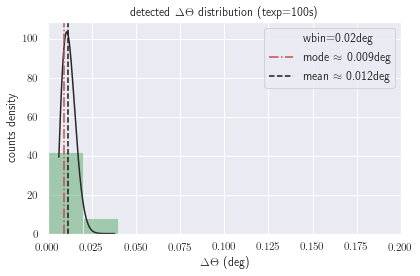

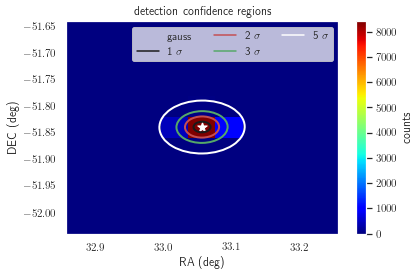

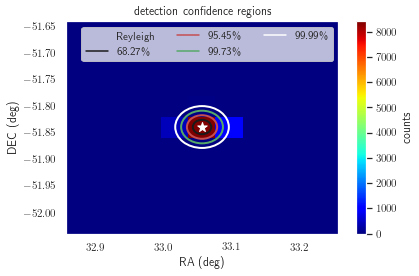

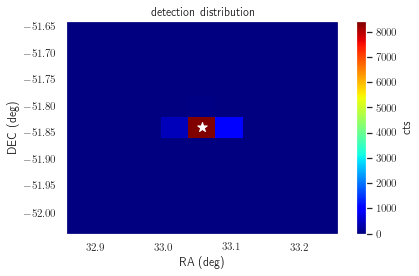



ok


In [6]:
# =============================
# !!! ALL STATISTICAL PLOTS !!!
# =============================

import matplotlib.pyplot as plt
import seaborn as sns
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from scipy.stats import rayleigh, norm
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse, Circle, Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from module_statistics import *

png_path = folder + 'png/'
# hist params ---!
Dwidth = 0.02
Dnbin = int(threshold / Dwidth)


for n in range(len(texp)) :  
        
    # store values ---!
    filename = csvMerged[n]
    
    # load DataFrame and column names ---!
    df = pd.read_csv(path+filename)
    cols = list(df.columns)
    trials = len(df[cols[0]])
    print('verify trials = ', trials)  if n == 0 else None
    # drop duplicates ---! 
    df.sort_values(cols[0], inplace = True) 
    # dropping ALL duplicte values 
    df.drop_duplicates(subset=cols[0], keep='last', inplace=True) 
    trials = len(df[cols[0]])
    print('verify trials = ', trials)  if n == 0 else None
    # drop NaN ---!
    df = df.dropna()

        
    print('\n\n================ texp = %ds ==============\n\n' %texp[n])
    
    # set arrays ---!
    trial = np.array(df[cols[0]])
    raDet = np.array(df[cols[4]])
    decDet = np.array(df[cols[5]])

    perc = 100 * (len(trial)/trials)
    print('ZERO DETECTION RATE :', 100-perc)
    print('DETECTION RATE :', perc)
    
    # DETECTION ---!
    distance_det = []
    d_det = []
    ra_det = []
    dec_det = []

    for i in range(len(raDet)) :
        if -90 <= decDet[i] and decDet[i] <= 90 and 0 <= raDet[i] and raDet[i] <= 360 :
            det_coord = SkyCoord(ra = raDet[i]*u.deg, dec = decDet[i]*u.deg, frame='fk5')
            dist = float(true_coord.separation(det_coord).deg)
            distance_det.append(dist)                  
    
            if dist < threshold :
                d_det.append(dist)
                ra_det.append(raDet[i]) 
                dec_det.append(decDet[i]) 
            
    perc_det = len(d_det)/trials * 100
    print('DET RATIO WITHIN %.1fdeg FROM TRUE POSITION:' %threshold, perc_det)
    
    # MEAN DET ---!
    mean_raDet = np.nanmean(ra_det)
    std_raDet = np.nanstd(ra_det)
    mean_decDet = np.nanmean(dec_det)
    std_decDet = np.nanstd(dec_det)
    mean_det = np.nanmean(d_det)
    std_det = np.nanstd(d_det)
    
    print('ra det mean:', mean_raDet, 'ra det std:', std_raDet)
    print('dec det mean:', mean_decDet, 'dec det std:', std_decDet)
    print('pos det mean:', mean_det, 'pos det std:', std_det)
    
    tmp = 0
    for i in range(len(d_det)) :
        tmp += d_det[i]**2
        
    if len(d_det) != 0.0 :
        mode_det = np.sqrt(1/(2*len(d_det)) * tmp)   
        MLE_det = 0.606/mode_det
    else:
        mode_det = np.nan
        MLE_det = np.nan
    

    
   
    # DETECTION 1D ---!
    fig, ax = hist1d_gauss(ra_det, mean_raDet, loc=trueRA, threshold=threshold, nbin=Dnbin, width=Dwidth,
                           fontsize=fontsize, color='g', 
                           title='detected RA distribution (texp=%ds)' %texp[n],
                           xlabel='RA (deg)', ylabel='counts density',
                           filename=png_path+'run0406_%ds_detRA.png' %texp[n])   
    plt.show()
    plt.close()
    
    fig, ax = hist1d_gauss(dec_det, mean_decDet, loc=trueDEC, nbin=Dnbin, width=Dwidth,
                           threshold=threshold, fontsize=fontsize, color='g', alpha=0.5,
                           title='detected DEC distribution (texp=%ds)' %texp[n],
                           xlabel='DEC (deg)', ylabel='counts density',
                           filename=png_path+'run0406_%ds_detDEC.png' %texp[n]) 
    plt.show()
    plt.close()
        
    fig, ax = hist1d_rayleigh(d_det, mean_det, rayleigh_prms={'loc':0, 'scale':mode_det}, 
                              nbin=Dnbin, width=Dwidth, fontsize=fontsize, color='g', threshold=threshold,
                              title='detected $\\Delta \\Theta$ distribution (texp=%ds)' %texp[n],
                              xlabel='$\\Delta \\Theta$ (deg)', ylabel='counts density',
                              filename=png_path+'run0406_%ds_DET.png' %texp[n])
    plt.show()
    plt.close()
        
    # DETECTION 2D ---!
    fig, ax = hist2d_gauss_CI(ra_det, dec_det, nbin=Dnbin, width=Dwidth, threshold=threshold, nstd=nstd,
                              xcentre=trueRA, ycentre=trueDEC,
                              colors=CI_colors, xlabel='RA (deg)', 
                              ylabel='DEC (deg)', title='detection confidence regions', fontsize=fontsize,
                              filename=png_path+'hist2d_%ds_DETgauss.png' %texp[n])
    
    plt.show()
    plt.close()
        
    fig, ax = hist2d_rayleigh_CI(ra_det, dec_det, nbin=Dnbin, width=Dwidth, threshold=threshold, 
                                 xcentre=trueRA, ycentre=trueDEC, rayleigh_prms={'loc':0,'scale':mode_det},
                                 probs=conf_probs, colors=CI_colors, 
                                 xlabel='RA (deg)', ylabel='DEC (deg)', 
                                 title='detection confidence regions', fontsize=fontsize, 
                                 filename=png_path+'hist2d_%ds_DETrayleigh.png' %texp[n])
    plt.show()
    plt.close()

    fig, ax = hist2d_map(ra_det, dec_det, trials, nbin=Dnbin, width=Dwidth, threshold=threshold,
                         xcentre=trueRA, ycentre=trueDEC, colors=CI_colors, 
                         xlabel='RA (deg)', ylabel='DEC (deg)', 
                         title='detection distribution', fontsize=fontsize, 
                         filename=png_path+'hist2d_%ds_DETmap.png' %texp[n], smooth=False)
    plt.show()
    plt.close()
    
    
print('\n\nok')


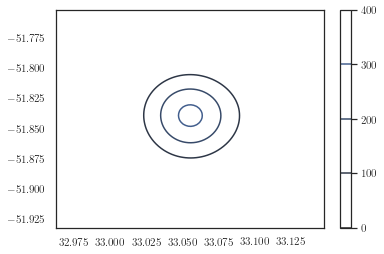

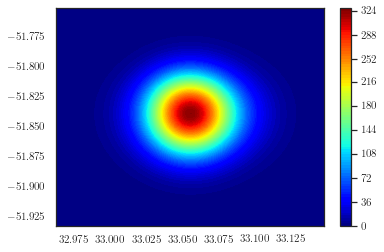

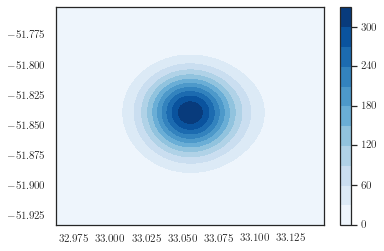

In [12]:
# KDE SIZE = SKYMAP PIXEL-SIZE

# library & dataset
import seaborn as sns
 
# Basic 2D density plot
sns.set_style("white")
sns.kdeplot(ra_det, dec_det, n_levels=3, bw=Dwidth, cbar=True)
plt.show()

# Custom it with the same argument as 1D density plot
sns.kdeplot(ra_det, dec_det, n_levels=100, cmap="jet", shade=True, bw=Dwidth, cbar=True)
plt.show()

# Some features are characteristic of 2D: color palette and wether or not color the lowest range
sns.kdeplot(ra_det, dec_det, cmap="Blues", shade=True, shade_lowest=True, bw=Dwidth, cbar=True)
plt.show()

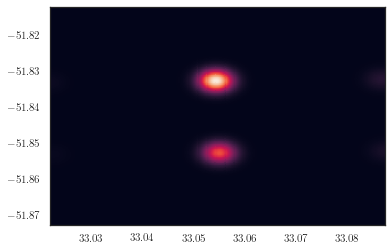

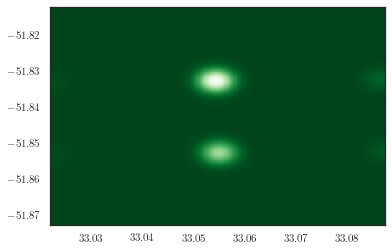

In [8]:
# ESTIMATE KDE FROM DATA

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kde
 
# create data
x = np.array(ra_det)
y = np.array(dec_det)
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.show()
 
# Change color palette
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Greens_r)
plt.show()
